In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import os
import datetime as dt
import gsw
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
import scipy.interpolate as sinterp
import cmocean
import json
import f90nml
from collections import OrderedDict
from scipy.stats.mstats import gmean

from sklearn.preprocessing import normalize

from sklearn.cluster import AgglomerativeClustering
import sklearn.metrics as sm

from scipy.cluster.vq import whiten
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

from pylab import rcParams
import seaborn as sb


fs=16
mpl.rc('xtick', labelsize=fs)
mpl.rc('ytick', labelsize=fs)
mpl.rc('legend', fontsize=fs)
mpl.rc('axes', titlesize=fs)
mpl.rc('axes', labelsize=fs)
mpl.rc('figure', titlesize=fs)
mpl.rc('font', size=fs)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

import warnings
#warnings.filterwarnings('ignore')
from IPython.display import Markdown, display



%matplotlib inline

### Import zooplankton observation data

In [2]:
SSzoop=pd.read_excel('/ocean/ksuchy/MOAD/analysis-karyn/notebooks/SalishSeaBiomassDF_DepthIntegrated.xlsx',engine='openpyxl')

In [3]:
SSzoop.keys()


Index(['Unnamed: 0', 'Unnamed: 0.1', 'Key', 'region_name', 'Lat', 'Lon',
       'Date', 'Z_lower', 'Z_upper', 'dtUTC', 'Year', 'YD', 'Total',
       'Copepods', 'Amphipods', 'Euphausiids', 'MainGroups',
       'MainNoLarvaceans', 'Gastropods', 'Chaetognaths', 'Crabs', 'Larvaceans',
       'Month', 'Total mg m2', 'Copepods mg m2', 'Amphipods mg m2',
       'Euphausiids mg m2', 'MainGroups mg m2', 'Gastropods mg m2',
       'Chaetognaths mg m2', 'Crabs mg m2', 'Larvaceans mg m2'],
      dtype='object')

In [4]:
#SS2015=SSzoop.loc[SSzoop.Year==2015]

In [5]:
SSspring=SSzoop.loc[(SSzoop.Month==3)|(SSzoop.Month==4)|(SSzoop.Month==5)].set_index('region_name')

In [6]:
SSspringMean=SSspring.groupby(['region_name']).mean()

In [7]:
SSspringMean

,Unnamed: 0,Unnamed: 0.1,Lat,Lon,Z_lower,Z_upper,Year,YD,Total,Copepods,...,Month,Total mg m2,Copepods mg m2,Amphipods mg m2,Euphausiids mg m2,MainGroups mg m2,Gastropods mg m2,Chaetognaths mg m2,Crabs mg m2,Larvaceans mg m2
region_name,,,,,,,,,,,,,,,,,,,,,
Admiralty Inlet,267.461538,267.461538,48.002730,-122.636000,114.692308,0.000000,2016.692308,112.000000,144.945357,14.807279,...,4.153846,16732.356057,1717.256947,3608.970014,4.378778,16654.379014,77.977044,71.041226,9313.492935,1939.239114
Baynes Sound,2071.325581,912.325581,49.525372,-124.801209,43.279070,0.000000,2015.906977,113.093023,132.880598,16.627738,...,4.139535,5588.242163,707.656885,46.787438,191.914658,1498.958653,382.287703,43.073978,561.147492,385.115976
Bellingham Bay,260.592593,260.592593,48.637950,-122.569400,106.629630,0.000000,2016.888889,112.037037,58.270999,8.392582,...,4.148148,6057.649050,908.287392,525.106830,16.718545,6004.307882,53.341168,50.515947,2594.291605,1909.387562
Central Basin,239.490000,239.490000,47.547290,-122.416320,190.050000,0.000000,2016.680000,104.630000,31.915236,6.706539,...,4.080000,6102.907975,1278.159002,1306.950067,58.763027,6047.944629,54.963347,102.055101,1453.345928,1848.671504
Central Strait of Georgia,1743.868421,584.868421,49.235342,-123.710039,242.796053,7.072368,2015.434211,104.881579,31.989908,11.519068,...,4.026316,7111.488866,2652.866049,772.644183,743.858672,4590.720909,682.248821,126.654567,424.542182,227.796471
Gulf Islands,1432.000000,273.000000,48.747345,-123.531613,53.142857,0.000000,2014.352941,114.630252,74.876995,5.531499,...,4.268908,3715.189616,360.971318,58.633789,47.940100,1076.734745,84.471594,51.103717,619.422477,221.945814
Hood Canal,256.380952,256.380952,47.638998,-122.854821,101.666667,0.000000,2017.357143,108.357143,44.781678,6.841409,...,4.095238,4516.581218,760.027084,818.909862,88.567628,4033.339962,483.241257,33.280414,1040.216906,1292.338068
Juan de Fuca,1856.142857,697.142857,48.319143,-124.055286,153.142857,0.000000,2016.285714,96.857143,31.665749,19.327062,...,3.857143,5282.597553,3224.473899,34.954905,79.275755,4091.599113,122.640079,1003.094191,333.826819,168.285416
Nearshore North West,2206.636364,1047.636364,49.536545,-124.727909,49.636364,0.000000,2016.272727,117.818182,63.074556,7.681830,...,4.545455,3166.550859,384.140093,19.331171,118.009209,706.799896,151.197358,2.999092,198.271293,167.656965


In [8]:
SSsummer=SSzoop.loc[(SSzoop.Month==6)|(SSzoop.Month==7)|(SSzoop.Month==8)].set_index('region_name')

In [9]:
SSsummerMean=SSsummer.groupby(['region_name']).mean()

In [10]:
SSautumn=SSzoop.loc[(SSzoop.Month==9)|(SSzoop.Month==10)|(SSzoop.Month==11)].set_index('region_name')

In [11]:
SSautumnMean=SSautumn.groupby(['region_name']).mean()

In [12]:
SSwinter=SSzoop.loc[(SSzoop.Month==12)|(SSzoop.Month==1)|(SSzoop.Month==2)].set_index('region_name')

In [13]:
SSwinterMean=SSwinter.groupby(['region_name']).mean()

In [14]:
column_names_to_normalize=['Copepods mg m2', 'Amphipods mg m2','Euphausiids mg m2','Gastropods mg m2','Chaetognaths mg m2', 'Crabs mg m2', 'Larvaceans mg m2']


In [15]:
SSspringMean_scaled=SSspringMean[column_names_to_normalize].apply(lambda x:(x-x.min())/(x.max()-x.min()))

In [16]:
#SSspringMean_scaled=normalize.(SSspringMean.column_names_to_normalize)

In [17]:
SSsummerMean_scaled=SSsummerMean[column_names_to_normalize].apply(lambda x:(x-x.min())/(x.max()-x.min()))


In [18]:
SSautumnMean_scaled=SSautumnMean[column_names_to_normalize].apply(lambda x:(x-x.min())/(x.max()-x.min()))

In [19]:
SSwinterMean_scaled=SSwinterMean[column_names_to_normalize].apply(lambda x:(x-x.min())/(x.max()-x.min()))

In [20]:
#Z=linkage(SS2015[column_names_to_normalize],'ward')

In [21]:
#dendrogram(Z,truncate_mode='lastp',p=12,leaf_rotation=45.,leaf_font_size=15.,show_contracted=True)
#plt.title('Truncated Hierarchical Clustering Dendrogram')
#plt.xlabel('Cluster Size')
#plt.ylabel('Distance')

#plt.show()

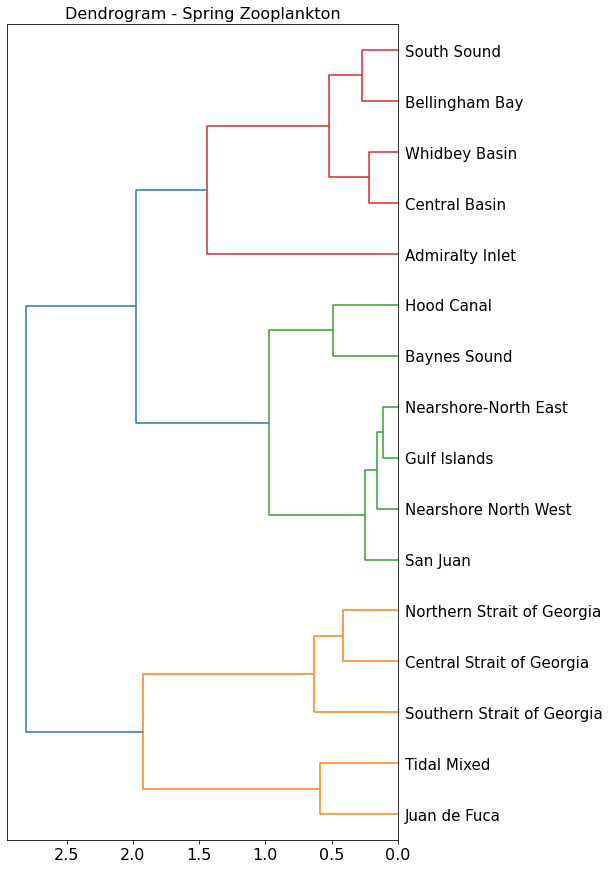

In [22]:


plt.figure(figsize=(7, 15)) 
plt.title("Dendrogram - Spring Zooplankton")  
#Z = dendrogram(linkage(SS2015may_scaled, method='ward'))
#dendrogram=(Z,orientation='bottom',labels=labels)
Z=linkage(SSspringMean_scaled,'ward')
dendrogram(Z,p=12,leaf_font_size=15.,orientation='left',show_contracted=True,labels=SSspringMean.index)
#plt.axhline(y=1.6, color='r', linestyle='--')

plt.show()


In [23]:
#SSspringMean

In [24]:
SSspringMean.index

Index(['Admiralty Inlet', 'Baynes Sound', 'Bellingham Bay', 'Central Basin',
       'Central Strait of Georgia', 'Gulf Islands', 'Hood Canal',
       'Juan de Fuca', 'Nearshore North West', 'Nearshore-North East',
       'Northern Strait of Georgia', 'San Juan', 'South Sound',
       'Southern Strait of Georgia', 'Tidal Mixed', 'Whidbey Basin'],
      dtype='object', name='region_name')

In [25]:
SSspringMean['Cluster']=np.nan

In [26]:
SSspringMean.loc[(SSspringMean.index=='South Sound')|(SSspringMean.index=='Bellingham Bay')|(SSspringMean.index=='Whidbey Basin')|(SSspringMean.index=='Central Basin')|(SSspringMean.index=='Admiralty Inlet'),['Cluster']]='Cluster 1'
SSspringMean.loc[(SSspringMean.index=='Hood Canal')|(SSspringMean.index=='Baynes Sound')|(SSspringMean.index=='Nearshore North West')|(SSspringMean.index=='Nearshore-North East')|(SSspringMean.index=='Gulf Islands')|(SSspringMean.index=='San Juan'),['Cluster']]='Cluster 2'
SSspringMean.loc[(SSspringMean.index=='Northern Strait of Georgia')|(SSspringMean.index=='Central Strait of Georgia')|(SSspringMean.index=='Southern Strait of Georgia')|(SSspringMean.index=='Tidal Mixed')|(SSspringMean.index=='Juan de Fuca'),['Cluster']]='Cluster 3'

In [27]:
SSspringMean.Cluster.unique()

array(['Cluster 1', 'Cluster 2', 'Cluster 3'], dtype=object)

In [28]:
import netCDF4 as nc

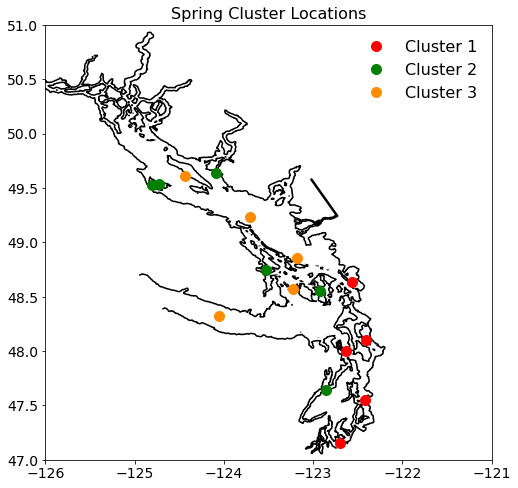

In [29]:
fig, ax = plt.subplots(1,1,figsize = (8,8))
with nc.Dataset('/ocean/ksuchy/MOAD/NEMO-forcing/grid/bathymetry_201702.nc') as grid:
    viz_tools.plot_coastline(ax, grid, coords = 'map',isobath=.1)
colors=('red','green','darkorange','deepskyblue','fuchsia','black','orange','firebrick','mediumspringgreen','royalblue','green','darkviolet',
        'lightblue','lime','darkgoldenrod','teal','darkgreen','darkblue','slateblue','purple')
datclus=dict()
for ind, icluster in enumerate(SSspringMean.Cluster.unique()):
    datclus[icluster] = SSspringMean.loc[SSspringMean.Cluster==icluster]
    ax.plot(datclus[icluster]['Lon'], datclus[icluster]['Lat'],'.',
            color = colors[ind], label=icluster,markersize=20)
ax.set_ylim(47, 51)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.legend(bbox_to_anchor=[1,.6,0,0])
ax.set_xlim(-126, -121);
ax.set_title('Spring Cluster Locations');
ax.legend(bbox_to_anchor=(1.0, 1), loc=1,frameon=False,markerscale=1.,fontsize=16)
#fig.savefig('SalishSeaObservationLocations.jpg',bbox_inches='tight')

In [30]:
SSspringMeanCopepods=SSspringMean.loc[:,['Copepods mg m2', 'Amphipods mg m2','Euphausiids mg m2','Gastropods mg m2','Chaetognaths mg m2', 'Crabs mg m2', 'Larvaceans mg m2']].groupby(['region_name'],as_index=False)\

SSspringMeanCopepods.head(50)

,Copepods mg m2,Amphipods mg m2,Euphausiids mg m2,Gastropods mg m2,Chaetognaths mg m2,Crabs mg m2,Larvaceans mg m2
region_name,,,,,,,
Admiralty Inlet,1717.256947,3608.970014,4.378778,77.977044,71.041226,9313.492935,1939.239114
Baynes Sound,707.656885,46.787438,191.914658,382.287703,43.073978,561.147492,385.115976
Bellingham Bay,908.287392,525.106830,16.718545,53.341168,50.515947,2594.291605,1909.387562
Central Basin,1278.159002,1306.950067,58.763027,54.963347,102.055101,1453.345928,1848.671504
Central Strait of Georgia,2652.866049,772.644183,743.858672,682.248821,126.654567,424.542182,227.796471
Gulf Islands,360.971318,58.633789,47.940100,84.471594,51.103717,619.422477,221.945814
Hood Canal,760.027084,818.909862,88.567628,483.241257,33.280414,1040.216906,1292.338068
Juan de Fuca,3224.473899,34.954905,79.275755,122.640079,1003.094191,333.826819,168.285416
Nearshore North West,384.140093,19.331171,118.009209,151.197358,2.999092,198.271293,167.656965


In [31]:
#SSspringMean.to_excel("SSspringMeanDIBiomass.xlsx")

In [32]:
SpringClusterMeans=(SSspringMean.groupby(['Cluster']).mean())/1000 #to get g m-2

In [33]:
springData=SpringClusterMeans[['Copepods mg m2','Amphipods mg m2','Euphausiids mg m2','Gastropods mg m2','Chaetognaths mg m2','Crabs mg m2','Larvaceans mg m2']]
springData.head()

,Copepods mg m2,Amphipods mg m2,Euphausiids mg m2,Gastropods mg m2,Chaetognaths mg m2,Crabs mg m2,Larvaceans mg m2
Cluster,,,,,,,
Cluster 1,1.261966,1.454783,0.025209,0.051982,0.056524,3.171931,1.912296
Cluster 2,0.464815,0.213012,0.084372,0.203878,0.025319,0.485268,0.502308
Cluster 3,2.568121,0.508021,0.768352,0.389520,0.495556,0.557209,0.256012


In [34]:
springData.rename(columns={'Copepods mg m2':'Copepods','Amphipods mg m2':'Amphipods','Euphausiids mg m2':'Euphausiids','Gastropods mg m2':'Gastropods','Chaetognaths mg m2':'Chaetognaths','Crabs mg m2':'Crabs','Larvaceans mg m2':'Larvaceans'},inplace=True)

/home/ksuchy/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/frame.py:4300: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


([<matplotlib.axis.YTick at 0x7f69fcd5fa90>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

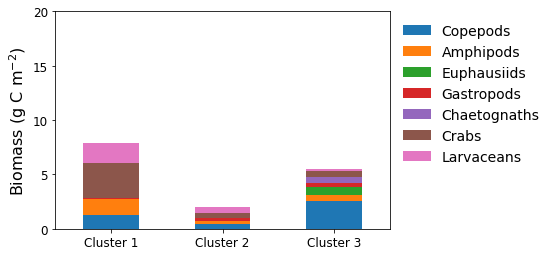

In [35]:
springData.plot(kind='bar',stacked=True)
plt.legend(bbox_to_anchor=(1.0, 1), loc=2,frameon=False,markerscale=1.,fontsize=14)
plt.xlabel('')
plt.ylabel('Biomass (g C m$^{-2}$)')
plt.xticks(rotation=360,fontsize=12)
y_ticks = np.arange(0, 20+1, 5)
plt.yticks(y_ticks,fontsize=12)



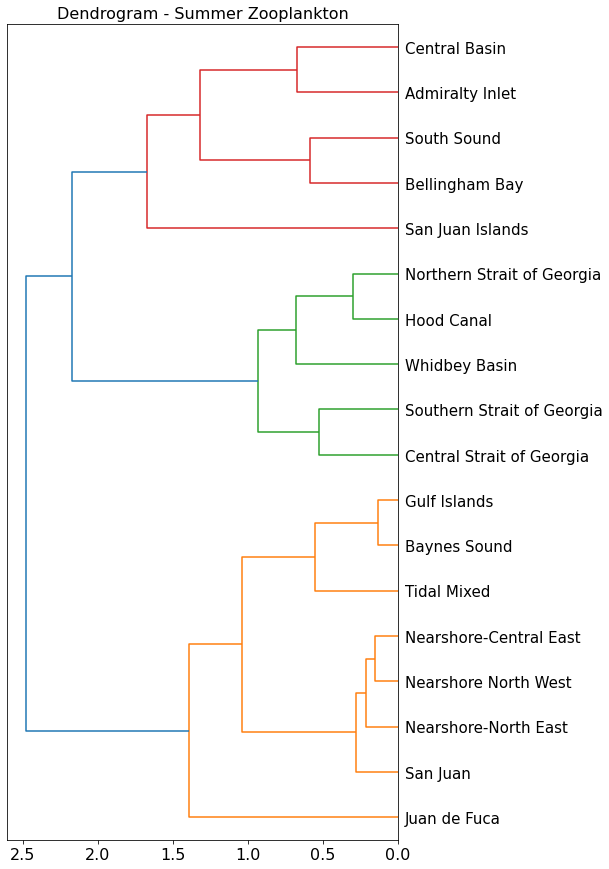

In [36]:

plt.figure(figsize=(7, 15)) 
plt.title("Dendrogram - Summer Zooplankton")  
#Z = dendrogram(linkage(SS2015may_scaled, method='ward'))
#dendrogram=(Z,orientation='bottom',labels=labels)
Z=linkage(SSsummerMean_scaled,'ward')
dendrogram(Z,p=12,leaf_font_size=15.,orientation='left',show_contracted=True,labels=SSsummerMean.index)
#plt.axhline(y=1.6, color='r', linestyle='--')

plt.show()

In [37]:
SSsummerMean['Cluster']=np.nan

In [38]:
SSsummerMean.index

Index(['Admiralty Inlet', 'Baynes Sound', 'Bellingham Bay', 'Central Basin',
       'Central Strait of Georgia', 'Gulf Islands', 'Hood Canal',
       'Juan de Fuca', 'Nearshore North West', 'Nearshore-Central East',
       'Nearshore-North East', 'Northern Strait of Georgia', 'San Juan',
       'San Juan Islands', 'South Sound', 'Southern Strait of Georgia',
       'Tidal Mixed', 'Whidbey Basin'],
      dtype='object', name='region_name')

In [39]:
SSsummerMean.loc[(SSsummerMean.index=='South Sound')|(SSsummerMean.index=='Bellingham Bay')|(SSsummerMean.index=='Central Basin')|(SSsummerMean.index=='Admiralty Inlet'),['Cluster']]='Cluster 1'
SSsummerMean.loc[(SSsummerMean.index=='San Juan Islands'),['Cluster']]='Cluster 2'
SSsummerMean.loc[(SSsummerMean.index=='Northern Strait of Georgia')|(SSsummerMean.index=='Hood Canal')|(SSsummerMean.index=='Whidbey Basin')|(SSsummerMean.index=='Central Strait of Georgia')|(SSsummerMean.index=='Southern Strait of Georgia'),['Cluster']]='Cluster 3'
SSsummerMean.loc[(SSsummerMean.index=='Tidal Mixed')|(SSsummerMean.index=='Juan de Fuca')|(SSsummerMean.index=='Baynes Sound')|(SSsummerMean.index=='Nearshore North West')|(SSsummerMean.index=='Nearshore-North East')|(SSsummerMean.index=='Gulf Islands')|(SSsummerMean.index=='Nearshore-Central East')|(SSsummerMean.index=='San Juan'),['Cluster']]='Cluster 4'

In [40]:
SSsummerMean.Cluster.unique()

array(['Cluster 1', 'Cluster 4', 'Cluster 3', 'Cluster 2'], dtype=object)

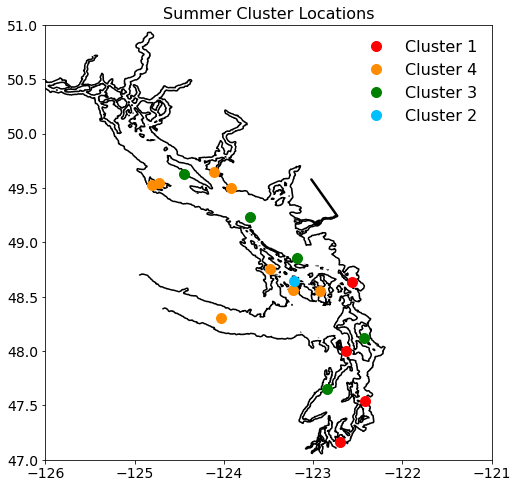

In [41]:
fig, ax = plt.subplots(1,1,figsize = (8,8))
with nc.Dataset('/ocean/ksuchy/MOAD/NEMO-forcing/grid/bathymetry_201702.nc') as grid:
    viz_tools.plot_coastline(ax, grid, coords = 'map',isobath=.1)
colors=('red','darkorange','green','deepskyblue','fuchsia','lime','black','orange','firebrick','mediumspringgreen','royalblue','green','darkviolet',
        'lightblue','darkgoldenrod','teal','darkgreen','darkblue','slateblue','purple')
datclus=dict()
for ind, icluster in enumerate(SSsummerMean.Cluster.unique()):
    datclus[icluster] = SSsummerMean.loc[SSsummerMean.Cluster==icluster]
    ax.plot(datclus[icluster]['Lon'], datclus[icluster]['Lat'],'.',
            color = colors[ind], label=icluster,markersize=20)
ax.set_ylim(47, 51)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.legend(bbox_to_anchor=[1,.6,0,0])
ax.set_xlim(-126, -121);
ax.set_title('Summer Cluster Locations');
ax.legend(bbox_to_anchor=(1.0, 1), loc=1,frameon=False,markerscale=1.,fontsize=16)
#fig.savefig('SalishSeaObservationLocations.jpg',bbox_inches='tight')

In [42]:
SSsummerMeanCopepods=SSsummerMean.loc[:,['Copepods mg m2', 'Amphipods mg m2','Euphausiids mg m2','Gastropods mg m2','Chaetognaths mg m2', 'Crabs mg m2', 'Larvaceans mg m2']].groupby(['region_name'],as_index=False)\

SSsummerMeanCopepods.head(50)

,Copepods mg m2,Amphipods mg m2,Euphausiids mg m2,Gastropods mg m2,Chaetognaths mg m2,Crabs mg m2,Larvaceans mg m2
region_name,,,,,,,
Admiralty Inlet,2132.936552,9373.522972,1.112631,103.676773,49.508053,862.666464,3666.239701
Baynes Sound,577.447302,74.142048,7.431142,142.299116,8.862589,556.210655,379.152813
Bellingham Bay,1206.392315,1987.886491,5.174363,146.908430,78.393399,311.068866,3871.739943
Central Basin,4215.060239,7297.795972,41.903304,269.095442,133.934552,796.142980,2144.738788
Central Strait of Georgia,3123.738131,1830.761064,1129.196774,1526.716742,627.399773,269.950530,94.412698
Gulf Islands,498.837844,117.331483,26.492452,107.228228,92.951931,428.383867,379.659967
Hood Canal,2730.715175,2143.608856,157.785645,705.635834,27.608541,209.727687,886.240253
Juan de Fuca,1668.421313,453.700262,6040.580439,2.318050,1799.219046,304.294417,31.179055
Nearshore North West,542.926427,53.202314,65.488402,15.425509,14.007965,115.050382,30.089332


In [43]:
#SSsummerMean.to_excel("SSsummerMeanDIBiomass.xlsx")

In [44]:
summerClusterMeans=(SSsummerMean.groupby(['Cluster']).mean())/1000 #to get g m-2

In [45]:
summerData=summerClusterMeans[['Copepods mg m2','Amphipods mg m2','Euphausiids mg m2','Gastropods mg m2','Chaetognaths mg m2','Crabs mg m2','Larvaceans mg m2']]
summerData.head()

,Copepods mg m2,Amphipods mg m2,Euphausiids mg m2,Gastropods mg m2,Chaetognaths mg m2,Crabs mg m2,Larvaceans mg m2
Cluster,,,,,,,
Cluster 1,2.298618,4.831793,0.012647,0.165964,0.071948,0.711517,3.466885
Cluster 2,3.584192,1.581044,0.137620,0.000000,7.267926,1.043112,0.733562
Cluster 3,3.177789,3.302465,0.526473,1.097197,0.515805,0.230060,0.722054
Cluster 4,0.697810,0.320493,0.808011,0.094295,0.390110,0.297492,0.305763


In [46]:
summerData.rename(columns={'Copepods mg m2':'Copepods','Amphipods mg m2':'Amphipods','Euphausiids mg m2':'Euphausiids','Gastropods mg m2':'Gastropods','Chaetognaths mg m2':'Chaetognaths','Crabs mg m2':'Crabs','Larvaceans mg m2':'Larvaceans'},inplace=True)

/home/ksuchy/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/frame.py:4300: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


([<matplotlib.axis.YTick at 0x7f69f403f100>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

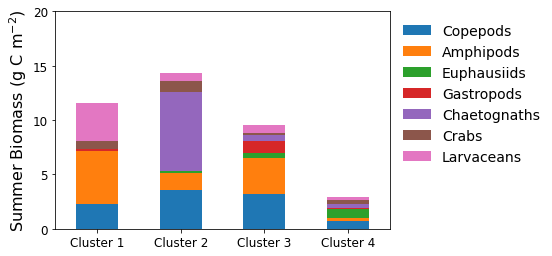

In [47]:

summerData.plot(kind='bar',stacked=True)
plt.legend(bbox_to_anchor=(1.0, 1), loc=2,frameon=False,markerscale=1.,fontsize=14)
plt.xlabel('')
plt.ylabel('Summer Biomass (g C m$^{-2}$)')
plt.xticks(rotation=360,fontsize=12)
y_ticks = np.arange(0, 20+1, 5)
plt.yticks(y_ticks,fontsize=12)


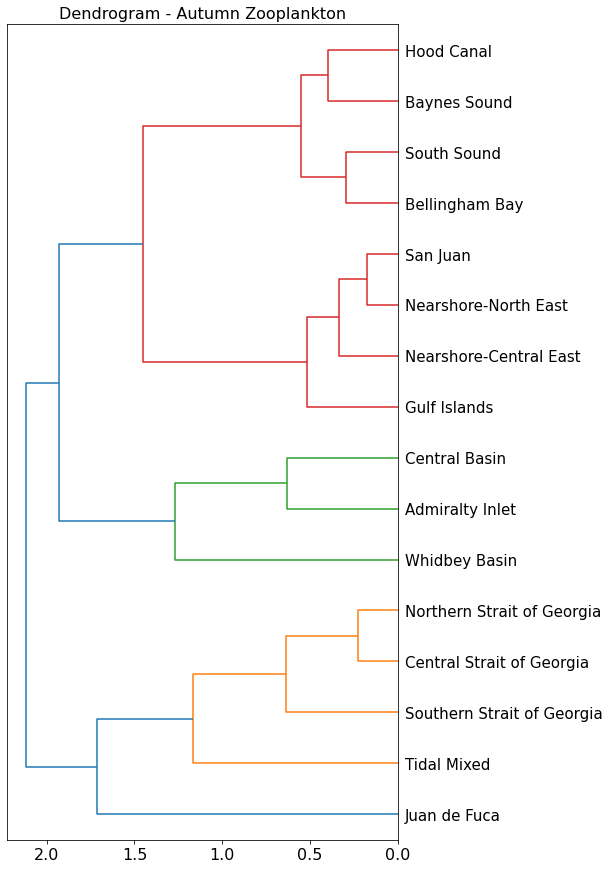

In [48]:

plt.figure(figsize=(7, 15)) 
plt.title("Dendrogram - Autumn Zooplankton")  
#Z = dendrogram(linkage(SS2015may_scaled, method='ward'))
#dendrogram=(Z,orientation='bottom',labels=labels)
Z=linkage(SSautumnMean_scaled,'ward')
dendrogram(Z,p=12,leaf_font_size=15.,orientation='left',show_contracted=True,labels=SSautumnMean.index)
#plt.axhline(y=1.6, color='r', linestyle='--')

plt.show()

In [49]:
SSautumnMean['Cluster']=np.nan

In [50]:
SSautumnMean.loc[(SSautumnMean.index=='South Sound')|(SSautumnMean.index=='Bellingham Bay')|(SSautumnMean.index=='Hood Canal')|(SSautumnMean.index=='Baynes Sound')|(SSautumnMean.index=='Nearshore-North East')|(SSautumnMean.index=='Gulf Islands')|(SSautumnMean.index=='Nearshore-Central East')|(SSautumnMean.index=='San Juan'),['Cluster']]='Cluster 1'
SSautumnMean.loc[(SSautumnMean.index=='Central Basin')|(SSautumnMean.index=='Admiralty Inlet')|(SSautumnMean.index=='Whidbey Basin'),['Cluster']]='Cluster 2'
SSautumnMean.loc[(SSautumnMean.index=='Tidal Mixed')|(SSautumnMean.index=='Northern Strait of Georgia')|(SSautumnMean.index=='Central Strait of Georgia')|(SSautumnMean.index=='Southern Strait of Georgia'),['Cluster']]='Cluster 3'
SSautumnMean.loc[(SSautumnMean.index=='Juan de Fuca'),['Cluster']]='Cluster 4'


In [51]:
SSautumnMean.Cluster.unique()

array(['Cluster 2', 'Cluster 1', 'Cluster 3', 'Cluster 4'], dtype=object)

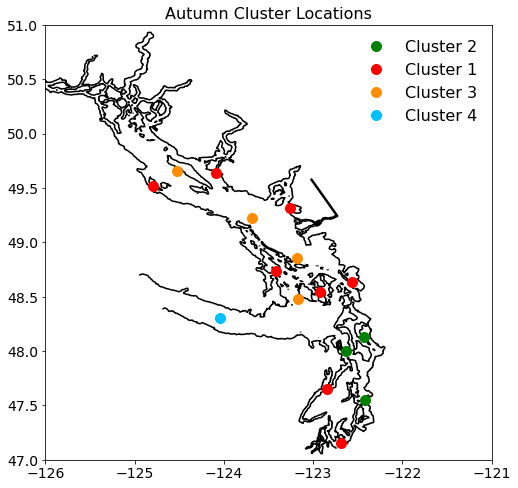

In [52]:
fig, ax = plt.subplots(1,1,figsize = (8,8))
with nc.Dataset('/ocean/ksuchy/MOAD/NEMO-forcing/grid/bathymetry_201702.nc') as grid:
    viz_tools.plot_coastline(ax, grid, coords = 'map',isobath=.1)
colors=('green','red','darkorange','deepskyblue','fuchsia','lime','black','orange','firebrick','mediumspringgreen','royalblue','green','darkviolet',
        'lightblue','darkgoldenrod','teal','darkgreen','darkblue','slateblue','purple')
datclus=dict()
for ind, icluster in enumerate(SSautumnMean.Cluster.unique()):
    datclus[icluster] = SSautumnMean.loc[SSautumnMean.Cluster==icluster]
    ax.plot(datclus[icluster]['Lon'], datclus[icluster]['Lat'],'.',
            color = colors[ind], label=icluster,markersize=20)
ax.set_ylim(47, 51)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.legend(bbox_to_anchor=[1,.6,0,0])
ax.set_xlim(-126, -121);
ax.set_title('Autumn Cluster Locations');
ax.legend(bbox_to_anchor=(1.0, 1), loc=1,frameon=False,markerscale=1.,fontsize=16)
#fig.savefig('SalishSeaObservationLocations.jpg',bbox_inches='tight')

In [53]:
SSautumnMeanCopepods=SSautumnMean.loc[:,['Copepods mg m2', 'Amphipods mg m2','Euphausiids mg m2','Gastropods mg m2','Chaetognaths mg m2', 'Crabs mg m2', 'Larvaceans mg m2']].groupby(['region_name'],as_index=False)\

SSautumnMeanCopepods.head(50)

,Copepods mg m2,Amphipods mg m2,Euphausiids mg m2,Gastropods mg m2,Chaetognaths mg m2,Crabs mg m2,Larvaceans mg m2
region_name,,,,,,,
Admiralty Inlet,760.204083,7350.762715,0.622900,142.708071,23.884462,148.176601,1344.655039
Baynes Sound,399.586066,36.958962,14.828093,264.827369,15.601047,29.761596,1690.739306
Bellingham Bay,770.539275,1045.379948,0.785645,90.182286,15.228398,67.497543,1769.023733
Central Basin,2551.043225,5419.077447,17.974137,295.652431,20.398494,75.087105,954.038930
Central Strait of Georgia,3049.180096,1943.358899,759.548252,430.783704,667.732122,109.724683,110.017948
Gulf Islands,446.329631,117.227337,6.585280,111.718848,56.180289,138.810410,616.997524
Hood Canal,1069.025820,1963.317167,47.646937,349.522532,8.146669,66.579950,1339.904304
Juan de Fuca,870.753632,215.231759,5646.880158,12.010813,3233.425590,95.010691,53.110183
Nearshore-Central East,335.306317,134.302928,44.979638,25.648350,96.965400,16.676887,2.970607


In [54]:
#SSautumnMean.to_excel("SSautumnMeanDIBiomass.xlsx")

In [55]:
autumnClusterMeans=(SSautumnMean.groupby(['Cluster']).mean())/1000 #to get g m-2

In [56]:
autumnData=autumnClusterMeans[['Copepods mg m2','Amphipods mg m2','Euphausiids mg m2','Gastropods mg m2','Chaetognaths mg m2','Crabs mg m2','Larvaceans mg m2']]
autumnData.head()

,Copepods mg m2,Amphipods mg m2,Euphausiids mg m2,Gastropods mg m2,Chaetognaths mg m2,Crabs mg m2,Larvaceans mg m2
Cluster,,,,,,,
Cluster 1,0.552215,0.600628,0.014793,0.118035,0.025425,0.062126,1.038243
Cluster 2,2.473806,5.534947,0.018090,0.420597,0.023061,0.079482,1.315212
Cluster 3,2.465487,1.189834,0.713279,0.362985,0.581157,0.156666,0.130077
Cluster 4,0.870754,0.215232,5.646880,0.012011,3.233426,0.095011,0.053110


In [57]:
autumnData.rename(columns={'Copepods mg m2':'Copepods','Amphipods mg m2':'Amphipods','Euphausiids mg m2':'Euphausiids','Gastropods mg m2':'Gastropods','Chaetognaths mg m2':'Chaetognaths','Crabs mg m2':'Crabs','Larvaceans mg m2':'Larvaceans'},inplace=True)

/home/ksuchy/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/frame.py:4300: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


([<matplotlib.axis.YTick at 0x7f69f413bbb0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

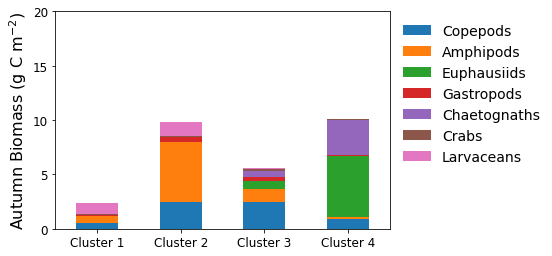

In [58]:
autumnData.plot(kind='bar',stacked=True)
plt.legend(bbox_to_anchor=(1.0, 1), loc=2,frameon=False,markerscale=1.,fontsize=14)
plt.xlabel('')
plt.ylabel('Autumn Biomass (g C m$^{-2}$)')
plt.xticks(rotation=360,fontsize=12)
y_ticks = np.arange(0, 20+1, 5)
plt.yticks(y_ticks,fontsize=12)

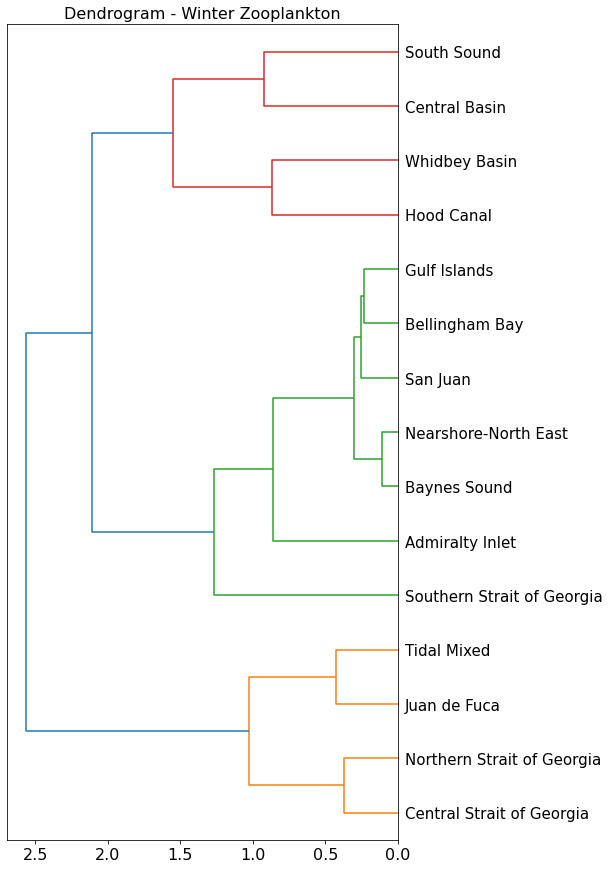

In [59]:

plt.figure(figsize=(7, 15)) 
plt.title("Dendrogram - Winter Zooplankton")  
#Z = dendrogram(linkage(SS2015may_scaled, method='ward'))
#dendrogram=(Z,orientation='bottom',labels=labels)
Z=linkage(SSwinterMean_scaled,'ward')
dendrogram(Z,p=12,leaf_font_size=15.,orientation='left',show_contracted=True,labels=SSwinterMean.index)
#plt.axhline(y=1.6, color='r', linestyle='--')

plt.show()

In [60]:
SSwinterMean['Cluster']=np.nan

In [61]:

SSwinterMean.loc[(SSwinterMean.index=='South Sound')|(SSwinterMean.index=='Central Basin')|(SSwinterMean.index=='Hood Canal')|(SSwinterMean.index=='Whidbey Basin'),['Cluster']]='Cluster 1'
SSwinterMean.loc[(SSwinterMean.index=='Baynes Sound')|(SSwinterMean.index=='Admiralty Inlet')|(SSwinterMean.index=='Bellingham Bay')|(SSwinterMean.index=='Nearshore-North East')|(SSwinterMean.index=='Gulf Islands')|(SSwinterMean.index=='San Juan')|(SSwinterMean.index=='Southern Strait of Georgia'),['Cluster']]='Cluster 2'
SSwinterMean.loc[(SSwinterMean.index=='Juan de Fuca')|(SSwinterMean.index=='Tidal Mixed')|(SSwinterMean.index=='Northern Strait of Georgia')|(SSwinterMean.index=='Central Strait of Georgia'),['Cluster']]='Cluster 3'



In [62]:
SSwinterMean.Cluster.unique()

array(['Cluster 2', 'Cluster 1', 'Cluster 3'], dtype=object)

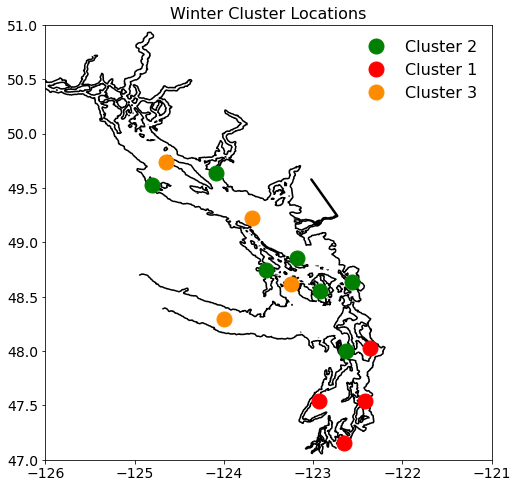

In [63]:
fig, ax = plt.subplots(1,1,figsize = (8,8))
with nc.Dataset('/ocean/ksuchy/MOAD/NEMO-forcing/grid/bathymetry_201702.nc') as grid:
    viz_tools.plot_coastline(ax, grid, coords = 'map',isobath=.1)
colors=('green','red','darkorange','deepskyblue','fuchsia','lime','black','orange','firebrick','mediumspringgreen','royalblue','green','darkviolet',
        'lightblue','darkgoldenrod','teal','darkgreen','darkblue','slateblue','purple')
winterclus=dict()
for ind, icluster in enumerate(SSwinterMean.Cluster.unique()):
    winterclus[icluster] = SSwinterMean.loc[SSwinterMean.Cluster==icluster]
    ax.plot(winterclus[icluster]['Lon'], winterclus[icluster]['Lat'],'.',
            color = colors[ind], label=icluster,markersize=30)
ax.set_ylim(47, 51)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.legend(bbox_to_anchor=[1,.6,0,0])
ax.set_xlim(-126, -121);
ax.set_title('Winter Cluster Locations');
ax.legend(bbox_to_anchor=(1.0, 1), loc=1,frameon=False,markerscale=1.,fontsize=16)
#fig.savefig('SalishSeaObservationLocations.jpg',bbox_inches='tight')

In [64]:
SSwinterMeanCopepods=SSwinterMean.loc[:,['Copepods mg m2', 'Amphipods mg m2','Euphausiids mg m2','Gastropods mg m2','Chaetognaths mg m2', 'Crabs mg m2', 'Larvaceans mg m2']].groupby(['region_name'],as_index=False)\

SSwinterMeanCopepods.head(50)

,Copepods mg m2,Amphipods mg m2,Euphausiids mg m2,Gastropods mg m2,Chaetognaths mg m2,Crabs mg m2,Larvaceans mg m2
region_name,,,,,,,
Admiralty Inlet,453.973071,1147.688414,79.445527,41.390361,241.156363,116.451427,70.328026
Baynes Sound,138.101772,7.646412,0.000000,116.100773,0.000000,76.034988,14.080248
Bellingham Bay,346.762678,377.556881,3.638170,26.393383,42.574628,162.848385,10.284119
Central Basin,1181.393148,2991.196929,1.633472,37.652341,135.984746,214.012800,435.121068
Central Strait of Georgia,1608.863042,630.503322,271.384545,111.039652,224.840960,214.747219,21.651449
Gulf Islands,116.242779,38.896122,14.179124,35.638386,26.743830,307.748865,25.132167
Hood Canal,476.288429,654.320591,48.537840,447.265731,20.314554,130.529596,114.791794
Juan de Fuca,930.219570,83.782773,173.785721,3.176560,511.292880,48.655111,12.086181
Nearshore-North East,159.610390,4.861993,0.000000,87.064120,2.064600,178.208111,21.811662


In [65]:
#SSwinterMean.to_excel("SSwinterMeanDIBiomass.xlsx")

In [66]:
winterClusterMeans=(SSwinterMean.groupby(['Cluster']).mean())/1000 #to get g m-2

In [67]:
winterData=winterClusterMeans[['Copepods mg m2','Amphipods mg m2','Euphausiids mg m2','Gastropods mg m2','Chaetognaths mg m2','Crabs mg m2','Larvaceans mg m2']]
winterData.head()

,Copepods mg m2,Amphipods mg m2,Euphausiids mg m2,Gastropods mg m2,Chaetognaths mg m2,Crabs mg m2,Larvaceans mg m2
Cluster,,,,,,,
Cluster 1,0.858970,1.701727,0.012749,0.230718,0.056434,0.207420,0.288176
Cluster 2,0.262126,0.249400,0.022257,0.056102,0.066727,0.305637,0.029811
Cluster 3,1.074087,0.333228,0.233360,0.063430,0.316954,0.120995,0.022526


In [68]:
winterData.rename(columns={'Copepods mg m2':'Copepods','Amphipods mg m2':'Amphipods','Euphausiids mg m2':'Euphausiids','Gastropods mg m2':'Gastropods','Chaetognaths mg m2':'Chaetognaths','Crabs mg m2':'Crabs','Larvaceans mg m2':'Larvaceans'},inplace=True)

/home/ksuchy/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/frame.py:4300: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


([<matplotlib.axis.YTick at 0x7f69eedb4910>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

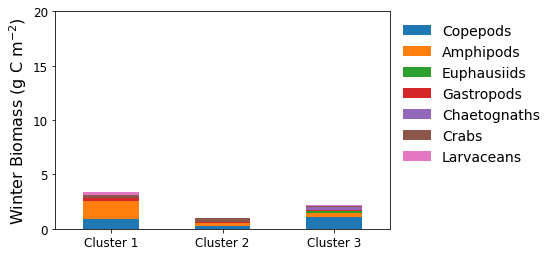

In [69]:
winterData.plot(kind='bar',stacked=True)
plt.legend(bbox_to_anchor=(1.0, 1), loc=2,frameon=False,markerscale=1.,fontsize=14)
plt.xlabel('')
plt.ylabel('Winter Biomass (g C m$^{-2}$)')
plt.xticks(rotation=360,fontsize=12)
y_ticks = np.arange(0, 20+1, 5)
plt.yticks(y_ticks,fontsize=12)